Make a chart showing the running total of fatality crashes by year. 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib._color_data import BASE_COLORS, TABLEAU_COLORS, CSS4_COLORS, XKCD_COLORS
from datetime import datetime
import pytz
import inflect
p = inflect.engine()

from crash_data_analysis import CrashDataAnalysis

In [2]:
# %%time
cda = CrashDataAnalysis()
df = cda.crash_dataframe(verbose=True)

Reading file: data/denver_crashes_2022_07_01__11_00.csv
Max timestamp: Wed Jun 29, 8:27 PM (1.65 days ago)
Fatality crashes this year: 40


In [3]:
# Aggregate fatality crashes by year and day of year

crashes_by_day_of_year = pd.pivot_table(
    data=df
    , values='fatality'
    # , values='sbi_or_fatality'
    # , values='one'
    , index='crash_day_of_year'
    , columns='crash_year'
    , aggfunc='sum'
    , fill_value=None
    )

running_total_crashes = crashes_by_day_of_year.cumsum()

this_year = datetime.now(tz=pytz.timezone('America/Denver')).year
max_day_of_year = df.reported_date.max().day_of_year

In [4]:
# Determine the number of days in each year. 365 normally, 366 for leap years

days_in_year = pd.Series(index=sorted(df.crash_year.unique()), dtype=int)

for year in sorted(df.crash_year.unique()):
    
    if year == this_year:
        days_in_year.loc[year] = max_day_of_year

    else:
        days_in_year.loc[year] = pd.Timestamp(year, 12, 31).dayofyear

In [5]:
# Make DataFrame with info about every month

first_of_month = pd.DataFrame({'month_int': range(1,13)})
first_of_month['month_str'] = first_of_month.apply(
    lambda row: pd.Timestamp(this_year, row.month_int, 1).strftime('%b'), axis=1)
first_of_month['day_of_year'] = first_of_month.apply(
    lambda row: pd.Timestamp(this_year, row.month_int, 1).day_of_year, axis=1)

first_of_month['label'] = first_of_month['month_str'] + '\n1'
first_of_month.loc[12, 'month_int'] = 13
first_of_month.loc[12, 'label'] = 'EOY'
first_of_month.loc[12, 'day_of_year'] = 366

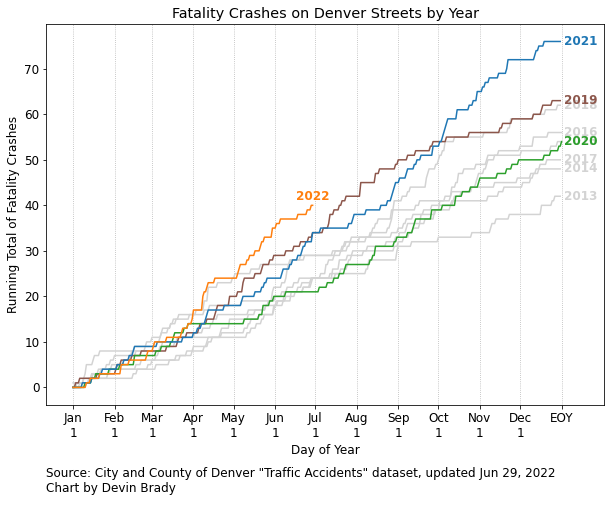

In [6]:
# Make the chart

matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica Neue') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(figsize=(10,7))

max_x_value = 380
plt.plot(range(0, max_x_value), [1] * max_x_value, alpha=0)

for year in sorted(df.crash_year.unique()):
    if year == 2019:
        color = 'tab:brown'
    elif year == 2020:
        color = 'tab:green'
    elif year == 2021:
        color = 'tab:blue'
    elif year == 2022:
        color = 'tab:orange'
    else:
        color = 'lightgray'
        
    plt.plot(running_total_crashes[year], label=year, color=color)
    
    # trendline
    # plt.plot([0, days_in_year[year]], [0, fatality_crashes_by_year[year]], color=color, linestyle=':')
    
    if year == this_year:
        annotation_x = max_day_of_year
        annotation_y = max(running_total_crashes[year]) + 2
    else:
        annotation_x = max_x_value
        annotation_y = max(running_total_crashes[year])

    ax.annotate(
        xy=(annotation_x, annotation_y)
        , text=year
        , color=color
        , fontweight='bold'
        , horizontalalignment='center'
        , verticalalignment='center'
    )

    
plt.xticks(ticks=first_of_month['day_of_year'], labels=first_of_month['label'])
plt.grid(axis='x', linestyle=':')

citation = f"""
Source: City and County of Denver "Traffic Accidents" dataset, updated {df.reported_date.max().strftime('%b %-d, %Y')}
Chart by Devin Brady
"""

ax.annotate(xy=(0, -0.2), text=citation, xycoords='axes fraction', ha='left', va='center')
plt.xlabel('Day of Year')
plt.ylabel('Running Total of Fatality Crashes')
plt.title('Fatality Crashes on Denver Streets by Year')
_ = plt.savefig('fatality_crashes_by_year.png', transparent=False, facecolor='white', bbox_inches='tight')

## Counts

In [7]:
fatality_crashes_by_year = df.groupby('crash_year').fatality.sum()
fatality_crashes_by_year

crash_year
2013    42
2014    48
2015    54
2016    56
2017    50
2018    62
2019    63
2020    54
2021    76
2022    40
Name: fatality, dtype: int64

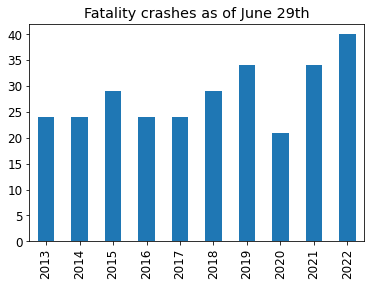

In [8]:
# Fatality crashes as of this day in the year
running_total_crashes.loc[max_day_of_year].plot(kind='bar')

date_string = df.reported_date.max().strftime('%B ')
date_string += p.ordinal(df.reported_date.max().strftime('%-d'))

plt.title(f"Fatality crashes as of {date_string}")

_ = plt.xlabel('')

In [9]:
days_per_fatality_crash = days_in_year / fatality_crashes_by_year
days_per_fatality_crash

2013    8.690476
2014    7.604167
2015    6.759259
2016    6.535714
2017    7.300000
2018    5.887097
2019    5.793651
2020    6.777778
2021    4.802632
2022    4.500000
dtype: float64

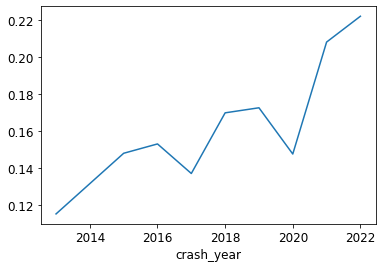

In [10]:
fatality_crash_per_day = fatality_crashes_by_year / days_in_year
_ = fatality_crash_per_day.plot()

crash_year
2013    42.000000
2014    48.000000
2015    54.000000
2016    56.000000
2017    50.000000
2018    62.000000
2019    63.000000
2020    54.000000
2021    76.000000
2022    81.111111
Name: fatality, dtype: float64

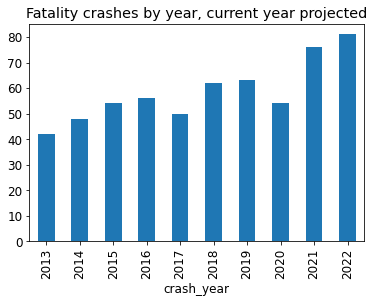

In [11]:
# Fatality crashes per year, current year projected
projected_fatality_crashes_by_year = fatality_crashes_by_year.astype(float).copy()
this_year = df.reported_date.max().year
projected_fatality_crashes_by_year[this_year] = (
    fatality_crash_per_day[this_year] * pd.Timestamp(this_year, 12, 31).dayofyear
)
projected_fatality_crashes_by_year.plot(kind='bar', title='Fatality crashes by year, current year projected')
projected_fatality_crashes_by_year

## Lists

In [12]:
f = cda.recent_fatality_crashes(df)

                 incident_address   neighborhood_id       crash_time_str  days_between  days_ago
  S SHERIDAN BLVD / W ALAMEDA AVE          Westwood   Sat Apr 9, 3:49 AM      0.260417 83.347298
           13600 BLOCK E 56TH AVE         Montbello Mon Apr 11, 10:44 PM      2.788194 80.559103
         W 38TH AVE / N QUIVAS ST          Highland  Tue Apr 12, 3:09 PM      0.684028 79.875076
       N SYRACUSE ST / E 14TH AVE       East Colfax  Sun Apr 17, 1:01 PM      4.911111 74.963964
   S JASON ST / S PLATTE RIVER DR         Ruby Hill  Wed May 4, 10:44 AM     16.904861 58.059103
      W YALE AVE / S FEDERAL BLVD Harvey Park South   Thu May 5, 9:23 PM      1.443750 56.615353
     E 56TH AVE / N WORCHESTER ST         Montbello   Fri May 6, 2:05 AM      0.195833 56.419520
     N COLORADO BLVD / E 48TH AVE    Elyria Swansea  Wed May 11, 4:51 PM      5.615278 50.804242
  I70 HWYWB / N CENTRAL PARK BLVD      Central Park Fri May 13, 11:07 AM      1.761111 49.043131
        N BIRCH ST / E COLFAX 

## Crashes on streets where traffic calming was removed

In [13]:
longitude_york = -104.95978236506068
longitude_colorado = -104.94071722366886

In [16]:
df.loc[
    (df.incident_address.str.contains('E 16TH AVE'))
    & (df.geo_lon < longitude_york)
    , ['incident_address', 'crash_time_str', 'top_traffic_accident_offense']
].tail(10)

,incident_address,crash_time_str,top_traffic_accident_offense
209677,E 16TH AVE / N GRANT ST,"Tue Apr 12, 11:30 PM",TRAF - ACCIDENT
214038,E 16TH AVE / N WASHINGTON ST,"Thu Apr 28, 7:00 PM",TRAF - ACCIDENT - HIT & RUN
210914,E 16TH AVE / N WASHINGTON ST,"Thu Apr 28, 7:00 PM",TRAF - ACCIDENT - HIT & RUN
211165,E 16TH AVE / N DOWNING ST,"Fri May 27, 8:57 AM",TRAF - ACCIDENT - SBI
210590,PARK AVE / E 16TH AVE,"Mon May 30, 11:36 AM",TRAF - ACCIDENT
206049,N PEARL ST / E 16TH AVE,"Wed Jun 8, 12:18 PM",TRAF - ACCIDENT - HIT & RUN
210923,PARK AVE / E 16TH AVE,"Fri Jun 17, 10:27 PM",TRAF - ACCIDENT - HIT & RUN
213784,PARK AVE / E 16TH AVE,"Fri Jun 24, 11:36 AM",TRAF - ACCIDENT
209802,E 16TH AVE / N PEARL WASHINGTON ALY,"Sun Jun 26, 10:47 AM",TRAF - ACCIDENT - HIT & RUN
205697,E 16TH AVE / N OGDEN ST,"Mon Jun 27, 10:06 PM",TRAF - ACCIDENT


In [17]:
df.loc[
    (df.incident_address.str.contains('E 17TH AVE'))
    & (df.geo_lon > longitude_york)
    & (df.geo_lon < longitude_colorado)
    , ['incident_address', 'crash_time_str', 'top_traffic_accident_offense']
].tail(10)

,incident_address,crash_time_str,top_traffic_accident_offense
204568,3000 BLOCK E 17TH AVE,"Fri May 14, 11:55 PM",TRAF - ACCIDENT - SBI
90447,3800 BLOCK E 17TH AVE,"Mon Jul 12, 7:04 AM",TRAF - ACCIDENT - HIT & RUN
1459,E 17TH AVE / N DETROIT ST,"Fri Aug 20, 5:52 PM",TRAF - ACCIDENT - POLICE
203100,E 17TH AVE / N MADISON MONROE ALY,"Thu Sep 30, 1:00 PM",TRAF - ACCIDENT
202580,N DETROIT ST / E 17TH AVE,"Wed Oct 6, 6:14 PM",TRAF - ACCIDENT - HIT & RUN
206464,E 17TH AVE / N COOK ST,"Mon Mar 14, 9:30 AM",TRAF - ACCIDENT
210558,N GARFIELD ST / E 17TH AVE,"Fri Apr 1, 8:31 PM",TRAF - ACCIDENT
210050,E 17TH AVE / N JOSEPHINE ST,"Tue Jun 14, 12:10 PM",TRAF - ACCIDENT
207549,2900 BLOCK E 17TH AVE,"Thu Jun 23, 11:25 AM",TRAF - ACCIDENT - HIT & RUN
213570,3600 BLOCK E 17TH AVE,"Sun Jun 26, 1:49 AM",TRAF - ACCIDENT - DUI/DUID
